In [40]:
#tab
import mmcv
from mmcv import Config
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)
from mmdet.models import build_detector
from mmdet.apis import single_gpu_test
from mmcv.runner import load_checkpoint
import os
from mmcv.parallel import MMDataParallel
import pandas as pd
from pandas import DataFrame
from pycocotools.coco import COCO
import numpy as np

import matplotlib.pyplot as plt
import cv2

import warnings
warnings.filterwarnings('ignore')

In [44]:
classes = ("General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")

##수정 가능
root = '/opt/ml/detection/'
csv_root = '/opt/ml/detection/mmdetection/work_dirs/faster_rcnn_r50_fpn_1x_trash/submission_latest.csv' #'/opt/ml/personel/output.csv'
viz_num = 16
thresh = 0.3
##이후 수정 불가능

if np.math.sqrt(viz_num) != int(np.math.sqrt(viz_num)):
    raise Exception('viz num은 제곱수로 입력해주세요')

In [45]:
def box2coord(bboxes: str):
    index = ['label', 'confidence', 'x_min', 'y_min','x_max', 'y_max']
    coordlist = []
    tmplist = {}
    for i, s in enumerate(bboxes.split()):
        if i % 6 == 0 and i != 0: 
            coordlist.append(tmplist)
            tmplist = {}
        
        if index[i%6] =='confidence':
            tmplist[index[i % 6]] = float(s)
        else:
            tmplist[index[i % 6]] = int(float(s))
        
    return coordlist

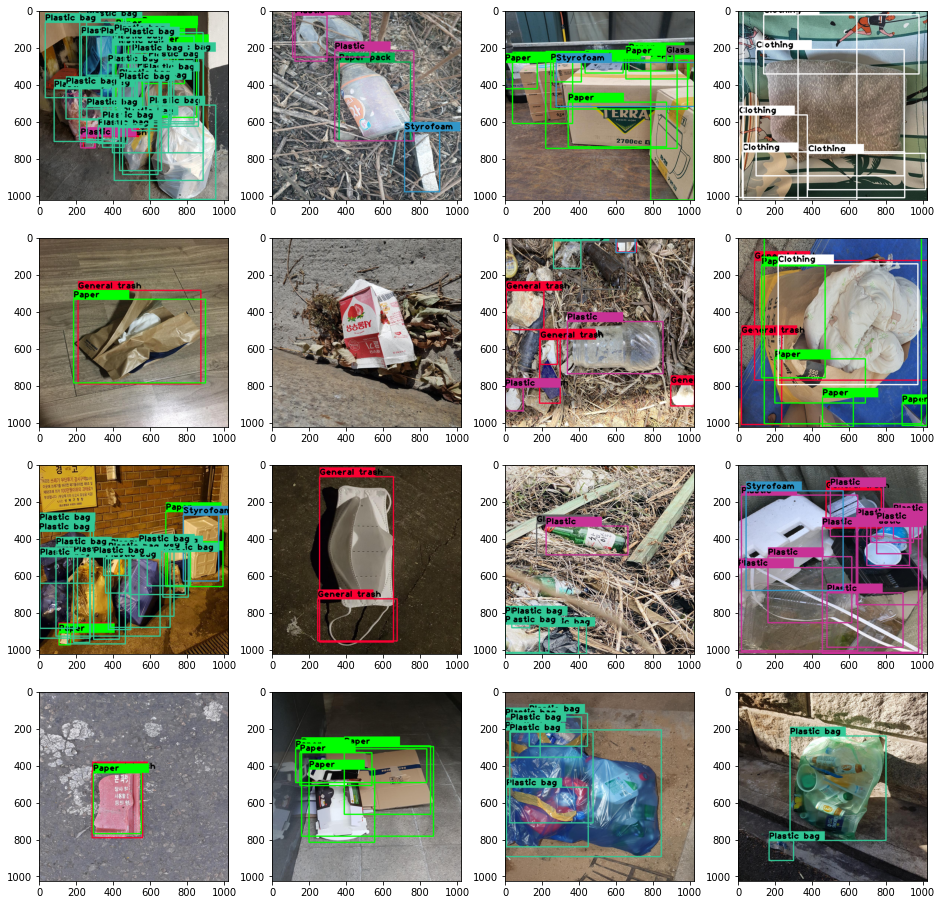

In [46]:
class_name_list = ['General trash', 'Paper', 'Paper pack', 'Metal', 'Glass', 'Plastic', 'Styrofoam', 'Plastic bag', 'Battery', 'Clothing']
class_color_list = [(250,0,50), (0, 255, 0), (0, 180, 80), (185, 185, 185), (100, 100, 100), (200, 50, 150), (50, 150, 200), (50, 200, 150), (200, 200, 200), (255,255,255)]
submission_set = pd.read_csv(csv_root)

plt.figure(figsize=(16,16))
for i, datas in enumerate(range(submission_set.shape[0])):
    if i == viz_num: break
    bboxes, img_dir = submission_set.iloc[i, :]
    bbox_list = box2coord(bboxes)
    image = cv2.imread(os.path.join(root, 'dataset/', img_dir))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    # image /= 255.0
    
    for box in bbox_list: 
        if box['confidence'] >= thresh:
            label_idx = box['label'] 
            cv2.rectangle(image, (box['x_max'], box['y_max']), (box['x_min'], box['y_min']), class_color_list[label_idx], 5)

            text = class_name_list[label_idx]    
            cv2.rectangle(image, (box['x_min'], box['y_min'] - 50), (box['x_min'] + 300, box['y_min']), class_color_list[label_idx], -1)
            cv2.putText(image, text, (int(box['x_min']), int(box['y_min'] - 10)), cv2.FONT_HERSHEY_PLAIN, 3, (0,0,0), 5, cv2.LINE_AA)

    plt.subplot(np.math.sqrt(viz_num), np.math.sqrt(viz_num), i+1)
    plt.imshow(image.astype(np.uint8))
    
    
plt.show()
